In [1]:
!pip install -q kaggle

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'

In [5]:
!chmod 600 /content/kaggle.json

In [6]:
!kaggle datasets download -d mashlyn/online-retail-ii-uci

Dataset URL: https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci
License(s): CC0-1.0
online-retail-ii-uci.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip /content/online-retail-ii-uci.zip

Archive:  /content/online-retail-ii-uci.zip
  inflating: online_retail_II.csv    


# Finding Data insight


In [8]:
import pandas as pd
import numpy as np

In [9]:
df = pd.read_csv('online_retail_II.csv')

In [10]:
df.shape

(1067371, 8)

In [11]:
# Order start with C is Cancelled
df = df[~df["Invoice"].str.startswith("C")]
df.shape

(1047877, 8)

In [12]:
df.dropna(inplace=True)
df.shape

(805620, 8)

In [14]:
invalid_codes = [item for item in set(df["StockCode"]) if not item[0].isdigit()]
invalid_codes

['ADJUST2',
 'BANK CHARGES',
 'D',
 'POST',
 'DOT',
 'TEST001',
 'SP1002',
 'TEST002',
 'M',
 'C2',
 'PADS',
 'ADJUST']

In [15]:
df = df[~df["StockCode"].isin(invalid_codes)]
df.shape

(802693, 8)

In [16]:
df["Sum"] = df["Quantity"] * df["Price"]
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Sum
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [21]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df.dtypes

,0
Invoice,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,datetime64[ns]
Price,float64
Customer ID,float64
Country,object
Sum,float64


In [22]:
df["Week"] = df["InvoiceDate"].dt.isocalendar().week
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Sum,Week
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,49
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,49
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,49
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,49
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,49


In [25]:
stat_df = df[["StockCode", "Week", "Sum"]].groupby(["StockCode", "Week"]).sum()
stat_df.reset_index(inplace=True)
stat_df.head()

,StockCode,Week,Sum
0,10002,1,73.95
1,10002,2,198.05
2,10002,3,97.75
3,10002,4,50.15
4,10002,5,125.80


In [26]:
data_df = stat_df.pivot(index="StockCode", columns="Week", values="Sum").fillna(0)
data_df.head()

Week,1,2,3,4,5,6,7,8,9,10,...,43,44,45,46,47,48,49,50,51,52
StockCode,,,,,,,,,,,,,,,,,,,,,
10002,73.95,198.05,97.75,50.15,125.8,37.40,40.8,167.45,333.90,20.40,...,44.20,144.50,3.40,534.55,39.95,123.25,293.25,50.15,30.60,11.05
10080,0.00,0.00,0.00,0.00,0.0,0.00,0.0,1.70,0.00,0.00,...,0.78,9.36,9.36,7.09,10.53,0.00,3.40,0.00,0.00,0.00
10109,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.68,0.00,0.00,0.00
10120,6.30,0.00,0.00,0.00,0.0,0.00,6.3,0.00,15.33,4.62,...,2.31,11.76,0.00,1.68,9.66,5.46,26.25,0.84,0.42,0.00
10123C,0.00,0.65,7.80,7.80,0.0,0.65,7.8,0.00,1.95,0.00,...,0.65,10.40,0.00,3.90,0.00,1.30,0.65,9.10,68.43,0.00


# Try Kmeans first

In [27]:
from sklearn.cluster import KMeans

In [28]:
MIN_K = 2
MAX_K = 20
results_kmeans = {}

In [29]:
for k in range(MIN_K, MAX_K+1):
  km = KMeans(n_clusters=k)
  km.fit(data_df)
  results_kmeans[k] = {
      'inertia': km.inertia_,
      'labels': km.labels_,
      'centroids': km.cluster_centers_,
      'n_iter': km.n_iter_
  }
  print(f"K={k} done with iteration: {km.n_iter_}, inertia: {km.inertia_}")

K=2 done with iteration: 2, inertia: 24716071243.94798
K=3 done with iteration: 2, inertia: 18766614957.792084
K=4 done with iteration: 27, inertia: 16244468204.086452
K=5 done with iteration: 9, inertia: 10941862276.415918
K=6 done with iteration: 12, inertia: 9327672488.08116
K=7 done with iteration: 9, inertia: 8220582968.344277
K=8 done with iteration: 14, inertia: 8606288689.19535
K=9 done with iteration: 9, inertia: 7053132514.088415
K=10 done with iteration: 22, inertia: 6664912023.279292
K=11 done with iteration: 37, inertia: 6553614771.88032
K=12 done with iteration: 24, inertia: 6055089279.853494
K=13 done with iteration: 50, inertia: 5809219206.888325
K=14 done with iteration: 15, inertia: 5708776032.072517
K=15 done with iteration: 14, inertia: 5636207638.969127
K=16 done with iteration: 19, inertia: 5373159071.308588
K=17 done with iteration: 15, inertia: 5144703925.7056465
K=18 done with iteration: 9, inertia: 5086618061.8886175
K=19 done with iteration: 19, inertia: 4928

In [31]:
import matplotlib.pyplot as plt

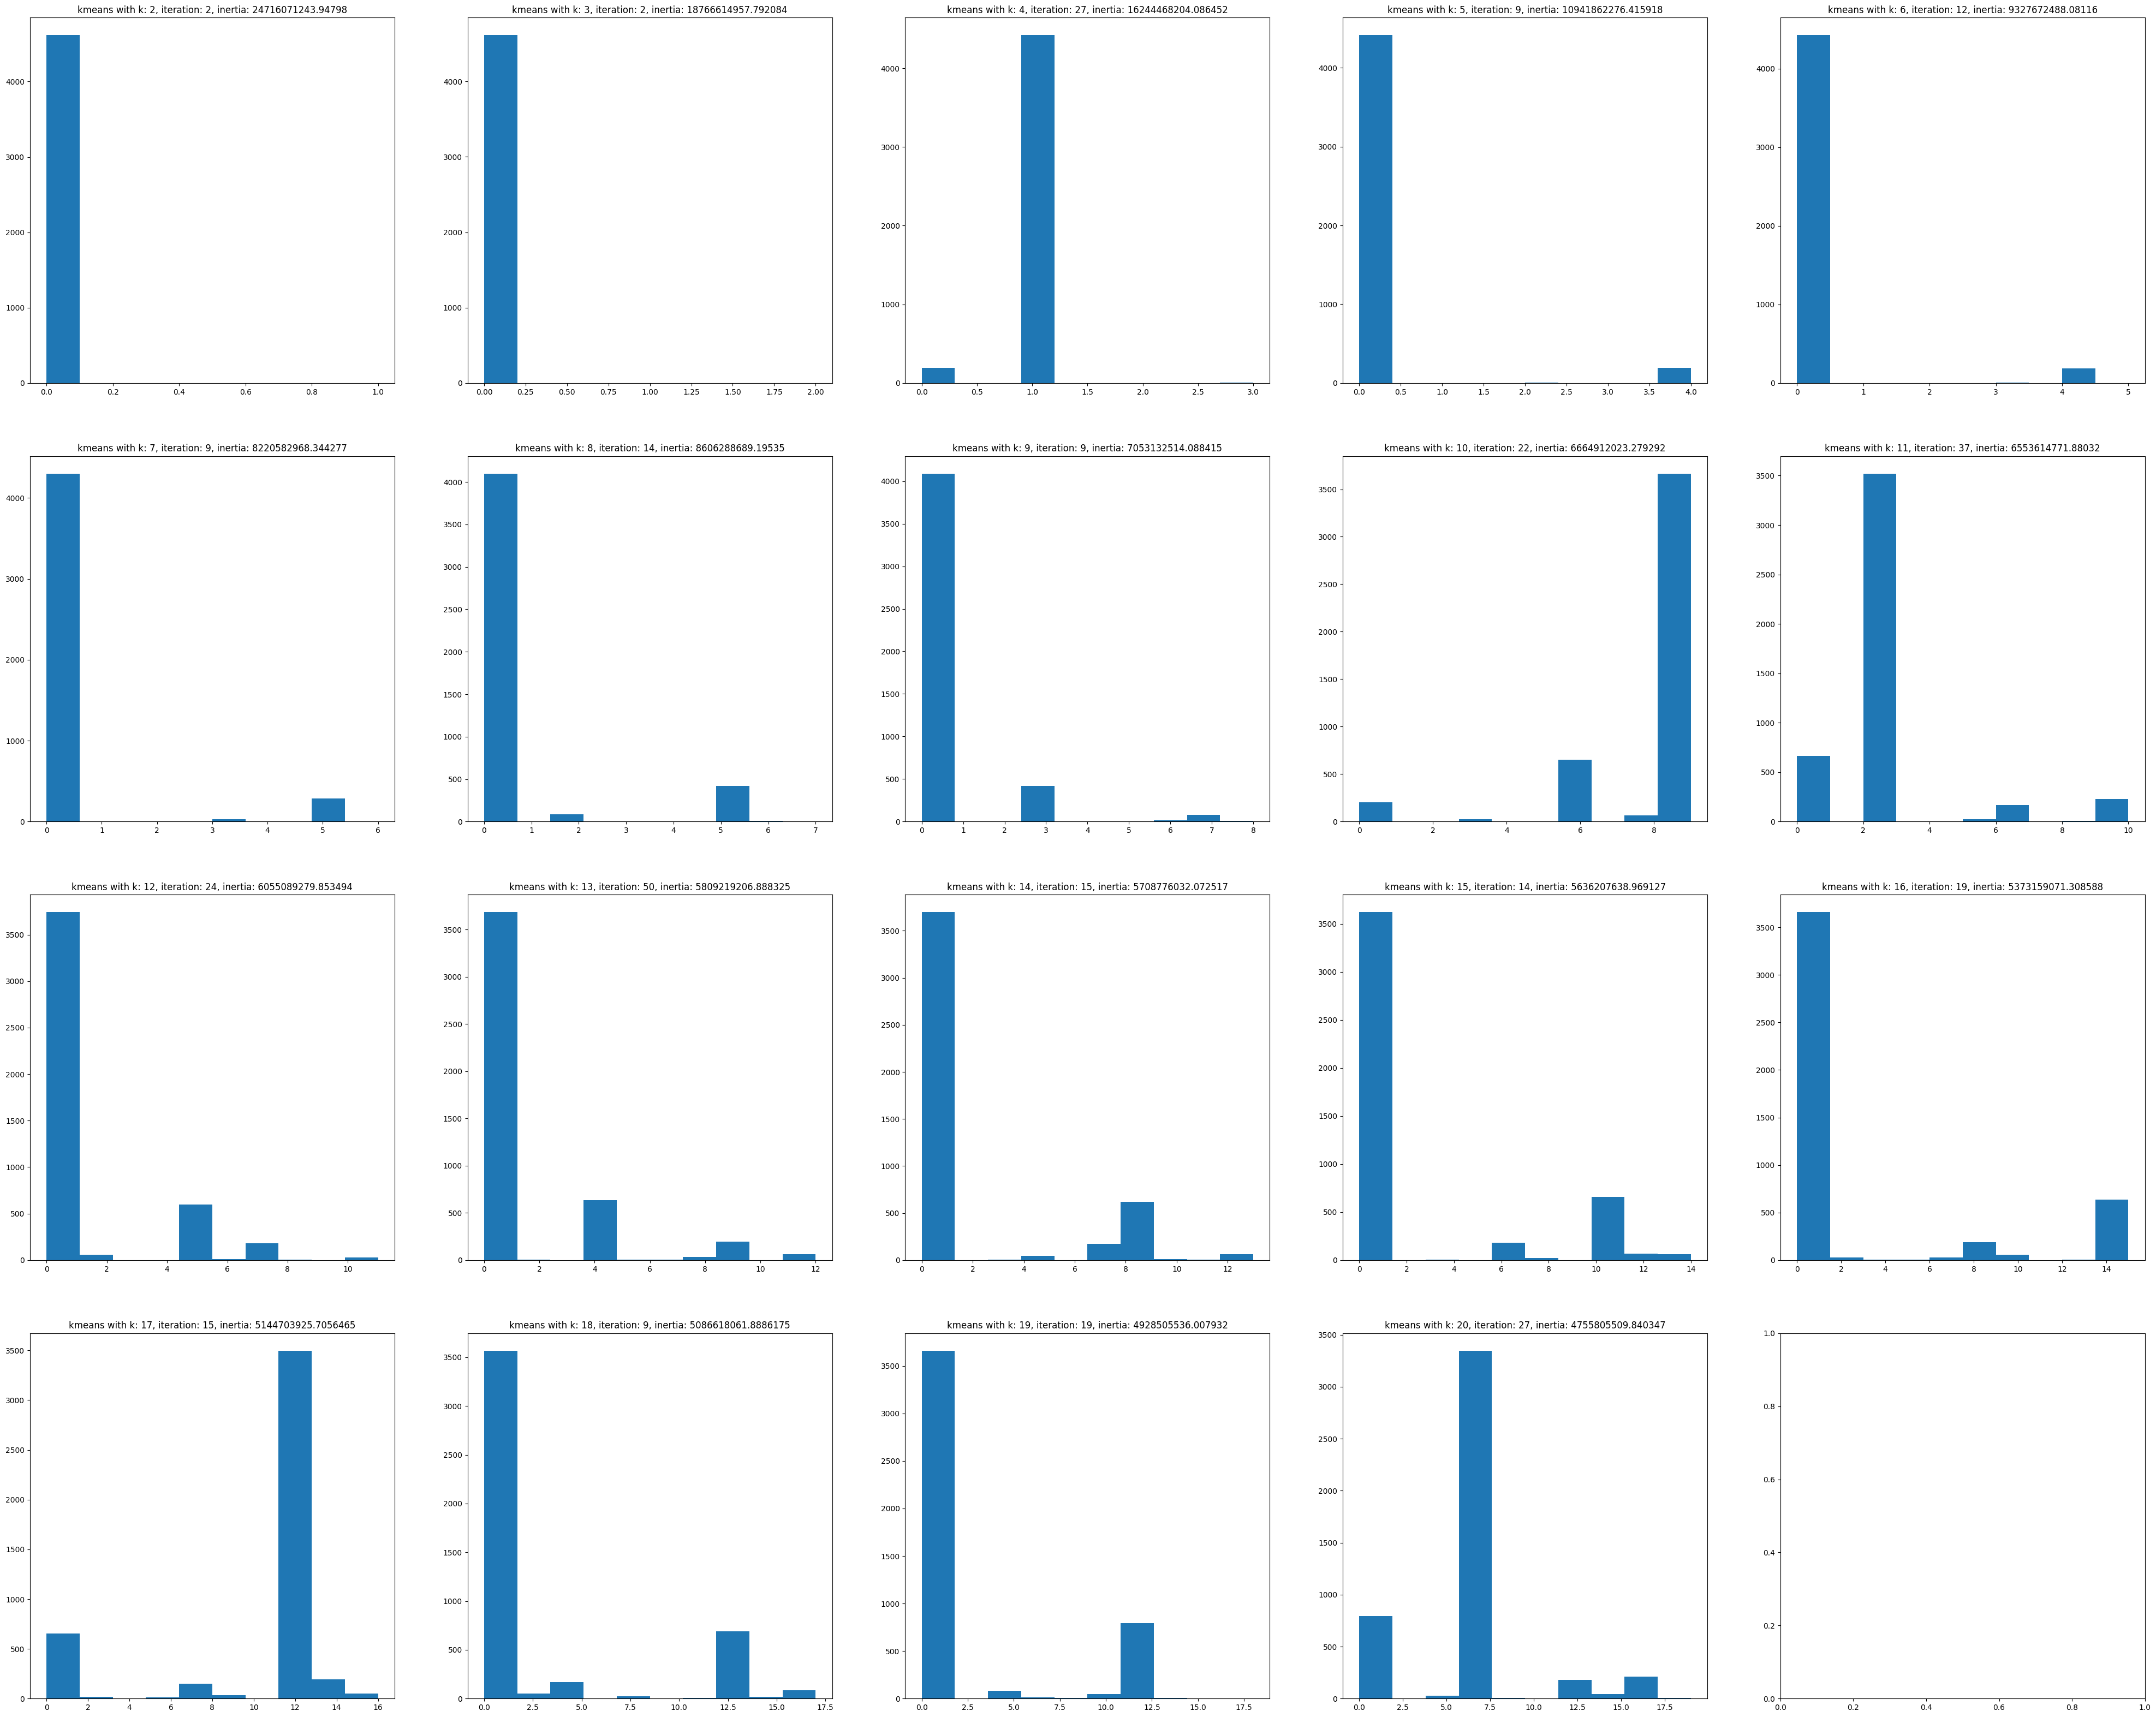

In [36]:
n_k = MAX_K - MIN_K + 1

ncols = 5
nrows = (n_k - 1) // ncols + 1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10*ncols, 10*nrows))

for i,k in enumerate(results_kmeans):
  row = i // ncols
  col = i % ncols

  axes[row][col].hist(results_kmeans[k]['labels'])
  axes[row][col].set_title(f'kmeans with k: {k}, iteration: {results_kmeans[k]["n_iter"]}, inertia: {results_kmeans[k]["inertia"]}')

plt.show()

In [37]:
# We dont know distribution of data
# So we will decide to choose k with have one cluster larger than other
# I decide to use k = 20 for visualization

In [38]:
from sklearn.decomposition import PCA

In [39]:
pca = PCA(n_components=2)

In [40]:
data_df.head()

Week,1,2,3,4,5,6,7,8,9,10,...,43,44,45,46,47,48,49,50,51,52
StockCode,,,,,,,,,,,,,,,,,,,,,
10002,73.95,198.05,97.75,50.15,125.8,37.40,40.8,167.45,333.90,20.40,...,44.20,144.50,3.40,534.55,39.95,123.25,293.25,50.15,30.60,11.05
10080,0.00,0.00,0.00,0.00,0.0,0.00,0.0,1.70,0.00,0.00,...,0.78,9.36,9.36,7.09,10.53,0.00,3.40,0.00,0.00,0.00
10109,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.68,0.00,0.00,0.00
10120,6.30,0.00,0.00,0.00,0.0,0.00,6.3,0.00,15.33,4.62,...,2.31,11.76,0.00,1.68,9.66,5.46,26.25,0.84,0.42,0.00
10123C,0.00,0.65,7.80,7.80,0.0,0.65,7.8,0.00,1.95,0.00,...,0.65,10.40,0.00,3.90,0.00,1.30,0.65,9.10,68.43,0.00


In [49]:
stock_2d = pca.fit_transform(data_df)

In [50]:
print(len(results_kmeans[20]['centroids'][0]), data_df.shape[1])

52 52


/tmp/ipython-input-3492915368.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[row][col].scatter(centroids[:,0], centroids[:,1], marker='x', s=100, cmap='tab20')
/tmp/ipython-input-3492915368.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[row][col].scatter(centroids[:,0], centroids[:,1], marker='x', s=100, cmap='tab20')
/tmp/ipython-input-3492915368.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[row][col].scatter(centroids[:,0], centroids[:,1], marker='x', s=100, cmap='tab20')
/tmp/ipython-input-3492915368.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[row][col].scatter(centroids[:,0], centroids[:,1], marker='x', s=100, cmap='tab20')
/tmp/ipython-input-3492915368.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axe

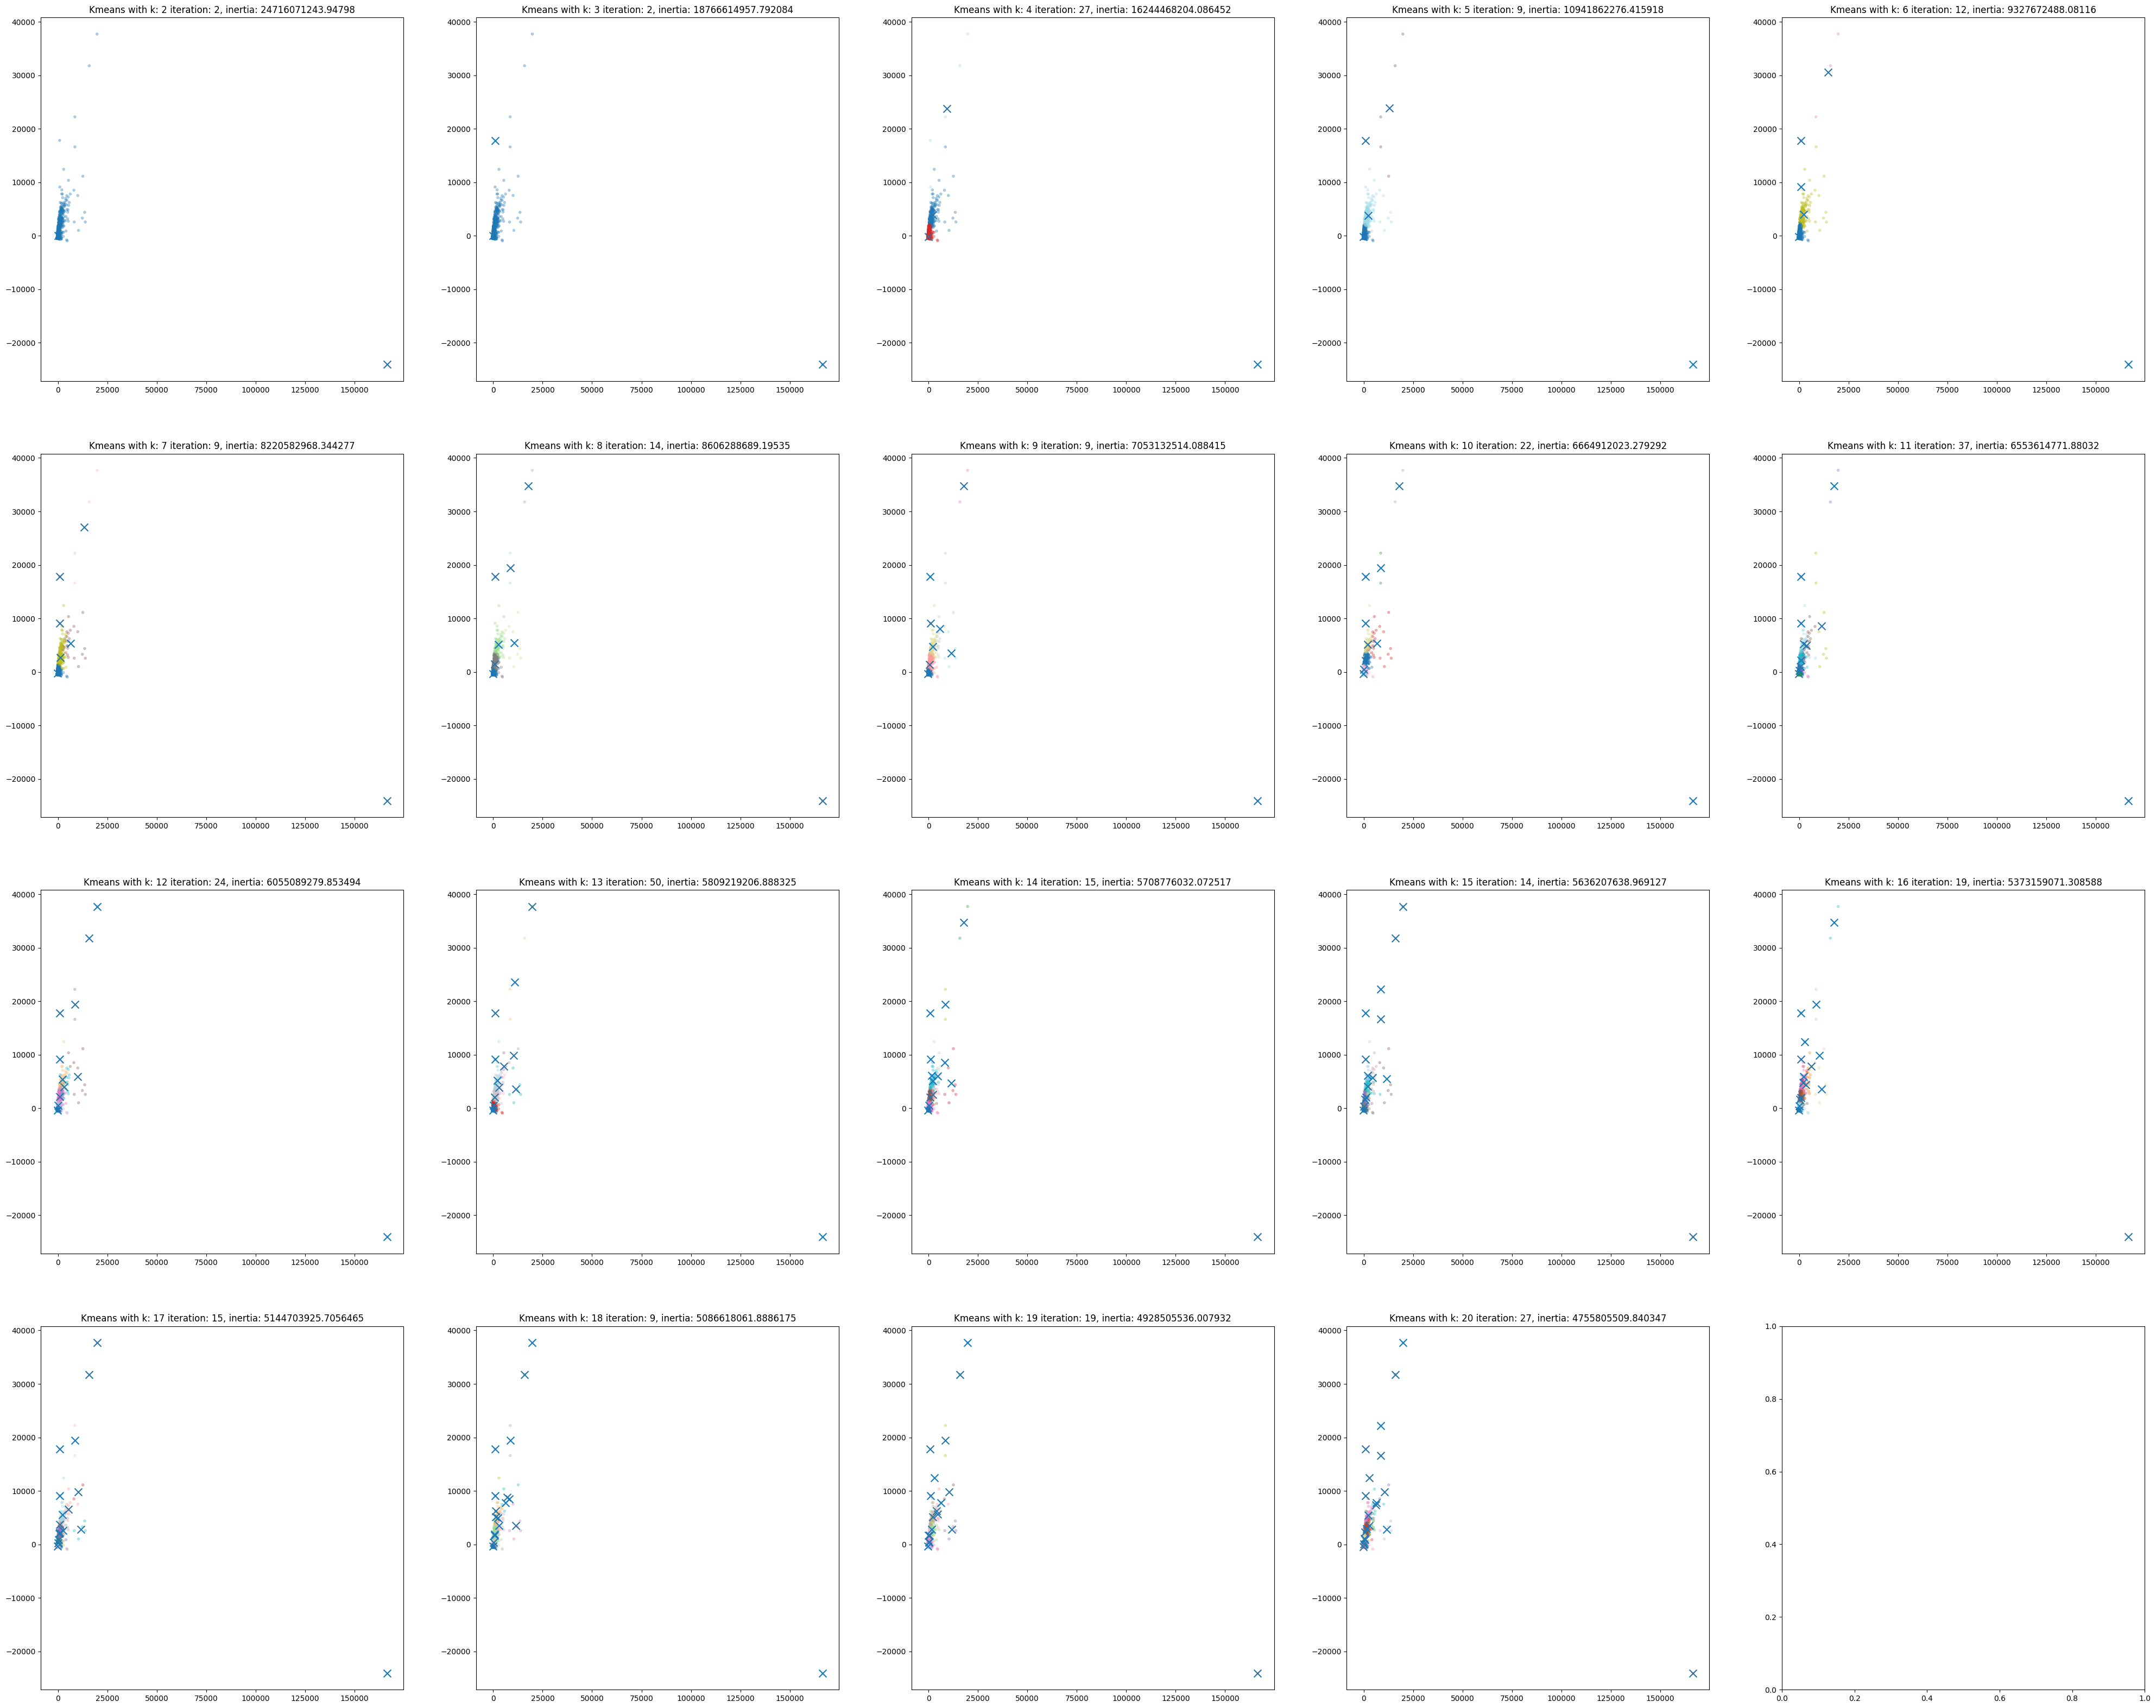

In [52]:
n_k = MAX_K - MIN_K + 1

ncols = 5
nrows = (n_k - 1) // ncols + 1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10*ncols, 10*nrows))

for i,k in enumerate(results_kmeans):
  row = i // ncols
  col = i % ncols

  centroids = pca.transform(results_kmeans[k]['centroids'])

  axes[row][col].scatter(stock_2d[:,0], stock_2d[:,1], marker='.', c=results_kmeans[k]['labels'], alpha=0.3, cmap='tab20')
  axes[row][col].scatter(centroids[:,0], centroids[:,1], marker='x', s=100, cmap='tab20')
  axes[row][col].set_title(f'Kmeans with k: {k} iteration: {results_kmeans[k]["n_iter"]}, inertia: {results_kmeans[k]["inertia"]}')

plt.show()

In [53]:
clusters = {}
for i in set(results_kmeans[20]['labels']):
  clusters[i] = data_df.iloc[np.where(results_kmeans[20]['labels'] == i)]
  print(f'Cluster {i} has {clusters[i].shape[0]} items')

Cluster 0 has 794 items
Cluster 1 has 1 items
Cluster 2 has 1 items
Cluster 3 has 1 items
Cluster 4 has 25 items
Cluster 5 has 1 items
Cluster 6 has 78 items
Cluster 7 has 3270 items
Cluster 8 has 2 items
Cluster 9 has 5 items
Cluster 10 has 1 items
Cluster 11 has 1 items
Cluster 12 has 43 items
Cluster 13 has 135 items
Cluster 14 has 42 items
Cluster 15 has 1 items
Cluster 16 has 1 items
Cluster 17 has 210 items
Cluster 18 has 6 items
Cluster 19 has 1 items


In [54]:
# Focus on cluster 4
clusters[4]

Week,1,2,3,4,5,6,7,8,9,10,...,43,44,45,46,47,48,49,50,51,52
StockCode,,,,,,,,,,,,,,,,,,,,,
21479,82.50,45.00,7.50,48.75,18.75,30.00,26.25,0.00,15.00,26.25,...,639.36,806.47,1118.72,2341.90,942.61,1911.77,2936.71,1466.22,1533.60,97.50
21485,965.65,1257.45,817.05,613.80,764.20,356.40,431.70,367.35,244.90,84.15,...,823.64,1886.25,1490.10,2075.83,2268.44,1888.05,2670.14,2830.50,2071.75,247.50
21915,309.40,90.00,141.25,92.50,613.95,31.25,47.50,152.50,656.20,350.65,...,418.39,4966.43,359.08,472.51,669.00,4922.70,417.50,360.66,1.25,0.00
22113,202.50,489.54,451.74,116.25,206.25,60.00,52.50,45.00,3.75,0.00,...,687.50,1057.75,1387.04,1269.04,1486.83,1498.83,2063.56,2266.89,447.54,0.00
22114,378.90,749.60,173.80,244.90,102.70,79.00,106.65,173.80,90.85,59.25,...,1436.23,1461.23,1946.50,2422.94,2080.85,2948.89,4433.34,1767.95,1748.35,418.10
22158,23.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.90,...,1074.75,1831.74,1121.00,2499.40,2167.14,1632.30,2037.19,188.80,20.65,0.00
22622,19.90,99.50,59.70,323.40,139.30,39.80,19.90,109.45,19.90,59.70,...,987.35,889.70,2542.60,774.30,630.95,974.26,5031.40,139.30,49.75,0.00
22632,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1286.40,1643.70,1369.50,2103.78,1519.50,2790.90,1758.00,0.00,0.00,0.00
22633,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.40,0.00,...,1612.20,1240.20,1386.30,2015.94,1285.20,3396.24,2259.90,0.00,0.00,0.00


In [59]:
clusters[4].sum()

,0
Week,
1,4820.53
2,4515.81
3,3748.90
4,2637.80
5,3282.06
6,1619.20
7,2090.62
8,1627.45
9,1749.60


In [64]:
clusters[12].sum()

,0
Week,
1,41177.54
2,49750.17
3,23827.10
4,31092.40
5,28697.60
6,21166.46
7,36795.12
8,39451.43
9,32199.25


In [73]:
(clusters[0] != 0).sum()

,0
Week,
1,506
2,500
3,523
4,522
5,502
6,490
7,527
8,531
9,547


In [74]:
clusters[0].sum()

,0
Week,
1,57254.77
2,45701.11
3,46618.59
4,47845.02
5,41248.49
6,32989.78
7,50647.25
8,53693.53
9,53121.83


In [67]:
df[df["StockCode"].isin(clusters[12].index)]["Description"].unique()

array(['STRAWBERRY CERAMIC TRINKET BOX',
       'FANCY FONT HOME SWEET HOME DOORMAT', 'HOME BUILDING BLOCK WORD',
       'PLEASE ONE PERSON  METAL SIGN', 'BAKING SET 9 PIECE RETROSPOT ',
       'RETRO SPOT TEA SET CERAMIC 11 PC ',
       'RED TOADSTOOL LED NIGHT LIGHT', 'JUMBO BAG PINK VINTAGE PAISLEY',
       'RED HANGING HEART T-LIGHT HOLDER',
       'VICTORIAN GLASS HANGING T-LIGHT',
       'JUMBO BAG SCANDINAVIAN PAISLEY', 'LUNCH BAG RED SPOTTY',
       'LUNCH BAG CARS BLUE', 'PAPER BUNTING RETRO SPOTS',
       'WOODEN FRAME ANTIQUE WHITE ', 'WOOD S/3 CABINET ANT WHITE FINISH',
       'PACK OF 72 RETRO SPOT CAKE CASES', 'DOOR MAT FAIRY CAKE',
       'PINK 3 PIECE MINI DOTS CUTLERY SET', 'JUMBO STORAGE BAG SUKI',
       'DOOR MAT NEW ENGLAND', 'RED SPOTTY COIR DOORMAT',
       'DOORMAT HEARTS', 'GIN + TONIC DIET METAL SIGN',
       'SET/5 RED SPOTTY LID GLASS BOWLS', 'EDWARDIAN PARASOL BLACK',
       'EDWARDIAN PARASOL NATURAL', 'LUNCH BAG  BLACK SKULL.',
       'JUMBO  BAG BAROQUE 

In [69]:
results_kmeans[20]['labels'][:10]

array([0, 7, 7, 7, 7, 7, 7, 7, 7, 7], dtype=int32)